In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import os
from scipy.misc import imread
import inception_v1
import json

In [2]:
with open('real-label.json', 'r') as fopen:
    labels = json.load(fopen)

In [3]:
img = imread('panda.jpg')
img.shape

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


(1000, 1500, 3)

In [4]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
X = tf.placeholder(tf.float32,[None,None,3])
image = X / 128.  - 1
image = tf.expand_dims(image, 0)
image = tf.image.resize_images(image, (224, 224))
with slim.arg_scope(inception_v1.inception_v1_arg_scope()):
    logits, endpoints = inception_v1.inception_v1(image,num_classes=1001,is_training=False)
sess.run(tf.global_variables_initializer())
var_lists = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = 'InceptionV1')
saver = tf.train.Saver(var_list = var_lists)
saver.restore(sess, 'inception_v1.ckpt')

INFO:tensorflow:Restoring parameters from inception_v1.ckpt


In [5]:
%%time
index = np.argmax(sess.run(logits,feed_dict={X:img})[0])
labels[str(index)]

CPU times: user 516 ms, sys: 208 ms, total: 724 ms
Wall time: 726 ms


In [6]:
endpoints

{'AvgPool_0a_7x7': <tf.Tensor 'InceptionV1/Logits/AvgPool_0a_7x7/AvgPool:0' shape=(1, 1, 1, 1024) dtype=float32>,
 'Conv2d_1a_7x7': <tf.Tensor 'InceptionV1/InceptionV1/Conv2d_1a_7x7/Relu:0' shape=(1, 112, 112, 64) dtype=float32>,
 'Conv2d_2b_1x1': <tf.Tensor 'InceptionV1/InceptionV1/Conv2d_2b_1x1/Relu:0' shape=(1, 56, 56, 64) dtype=float32>,
 'Conv2d_2c_3x3': <tf.Tensor 'InceptionV1/InceptionV1/Conv2d_2c_3x3/Relu:0' shape=(1, 56, 56, 192) dtype=float32>,
 'Logits': <tf.Tensor 'InceptionV1/Logits/SpatialSqueeze:0' shape=(1, 1001) dtype=float32>,
 'MaxPool_2a_3x3': <tf.Tensor 'InceptionV1/InceptionV1/MaxPool_2a_3x3/MaxPool:0' shape=(1, 56, 56, 64) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV1/InceptionV1/MaxPool_3a_3x3/MaxPool:0' shape=(1, 28, 28, 192) dtype=float32>,
 'MaxPool_4a_3x3': <tf.Tensor 'InceptionV1/InceptionV1/MaxPool_4a_3x3/MaxPool:0' shape=(1, 14, 14, 480) dtype=float32>,
 'MaxPool_5a_2x2': <tf.Tensor 'InceptionV1/InceptionV1/MaxPool_5a_2x2/MaxPool:0' shape=(1,

In [7]:
Conv2d_1a_7x7 = sess.run(endpoints['Conv2d_1a_7x7'],feed_dict={X:img})[0]
Conv2d_1a_7x7.shape

(112, 112, 64)

In [8]:
import matplotlib.pyplot as plt

plt.imshow(Conv2d_1a_7x7[:, :, 0], cmap='viridis')
plt.show()

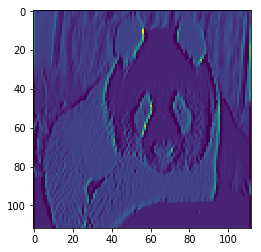

In [9]:
plt.imshow(Conv2d_1a_7x7[:, :, -1], cmap='viridis')
plt.show()

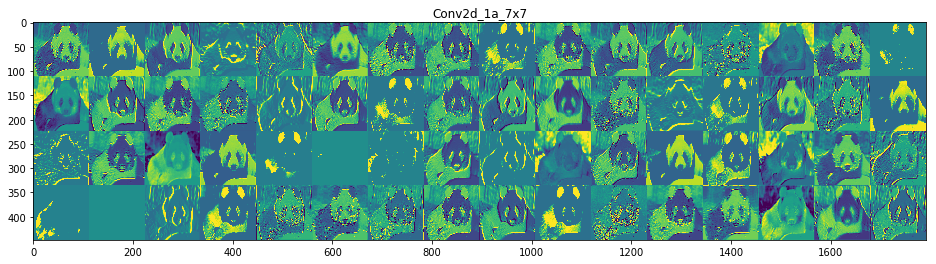

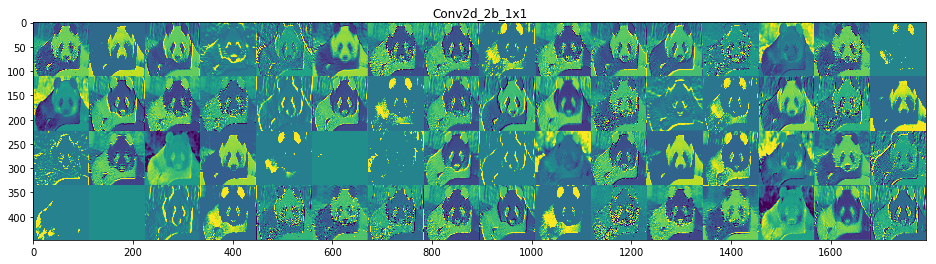

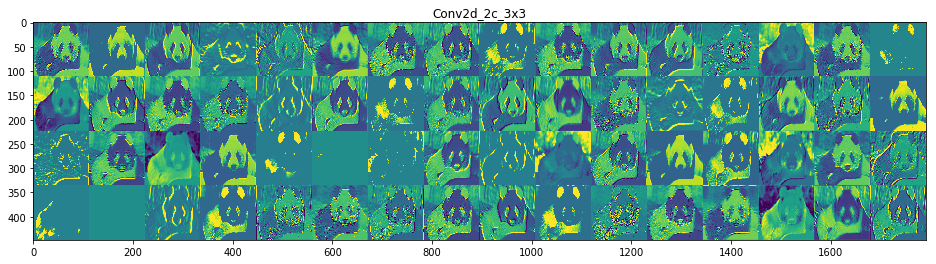

In [10]:
images_per_row = 16

for layer_name in ['Conv2d_1a_7x7','Conv2d_2b_1x1','Conv2d_2c_3x3']:
    
    layer_activation = sess.run(endpoints['Conv2d_1a_7x7'],feed_dict={X:img})[0]
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[:, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

In [11]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_pattern(layer_name, filter_index, size=150, epoch=40):
    loss = tf.reduce_mean(endpoints[layer_name][:,:,:,filter_index])
    grad = tf.gradients(loss, X)[0]
    grad /= (tf.sqrt(tf.reduce_mean(tf.square(grad))) + 1e-5)
    input_img_data = np.random.random((size, size, 3)) * 20 + 128.
    for i in range(epoch):
        grad_val = sess.run(grad,feed_dict={X:input_img_data})
        input_img_data += grad_val
    
    return deprocess_image(input_img_data)

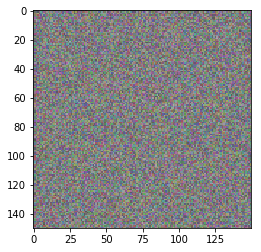

In [12]:
plt.imshow(generate_pattern('Conv2d_1a_7x7', -1))
plt.show()

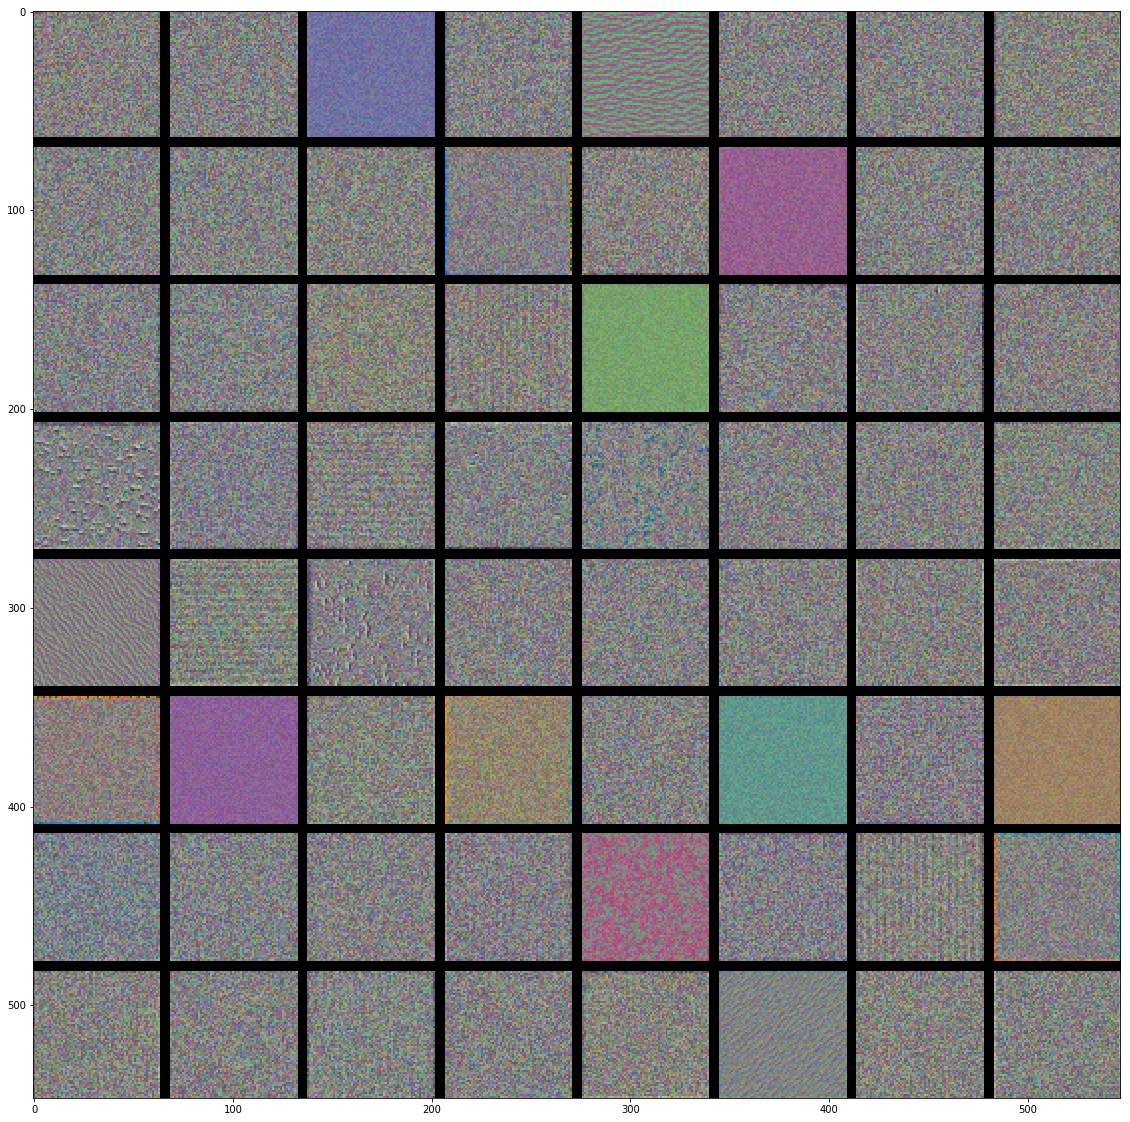

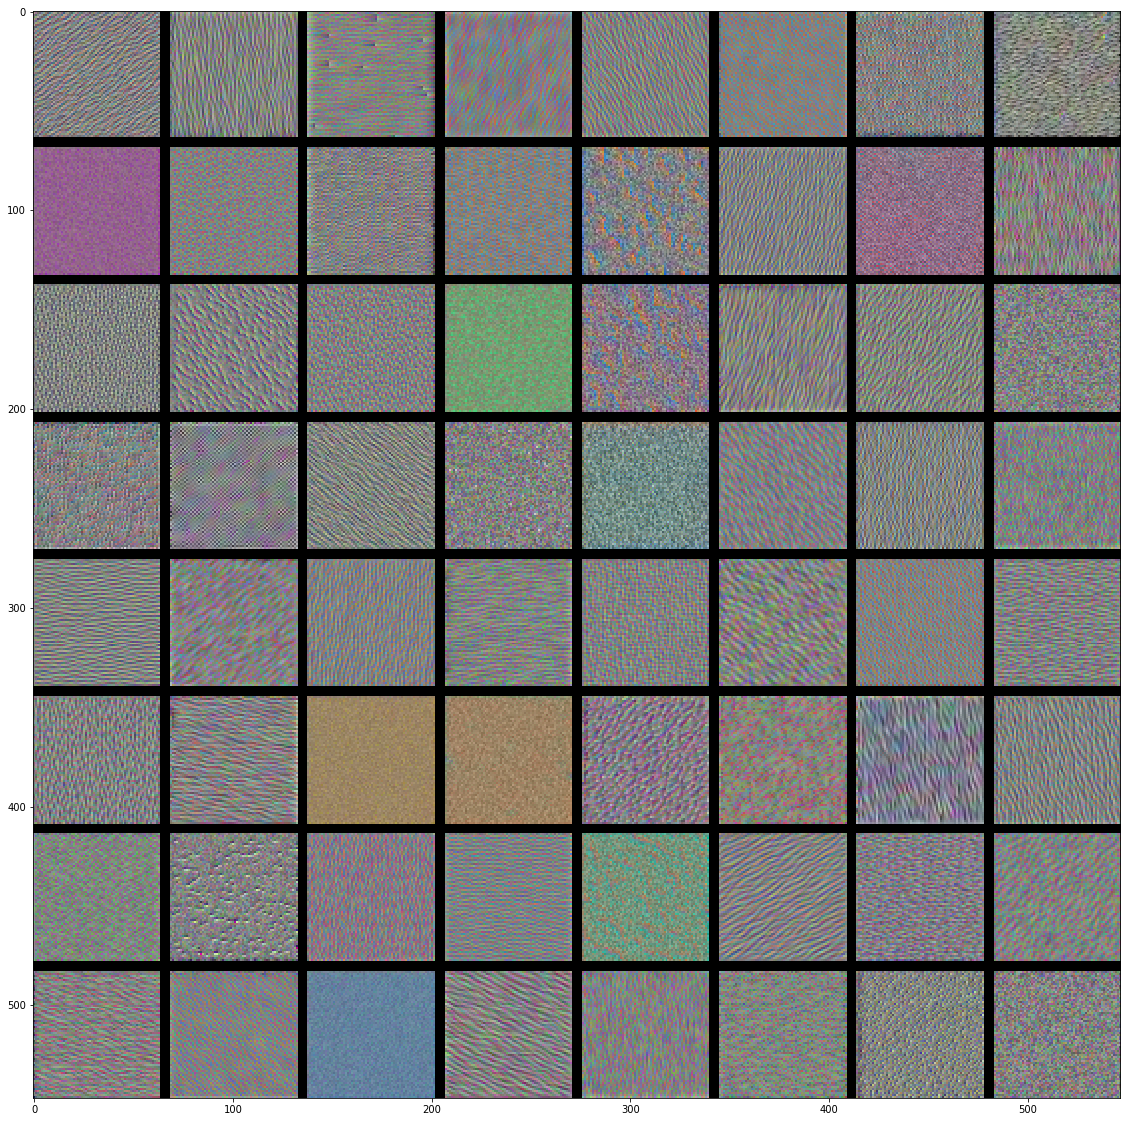

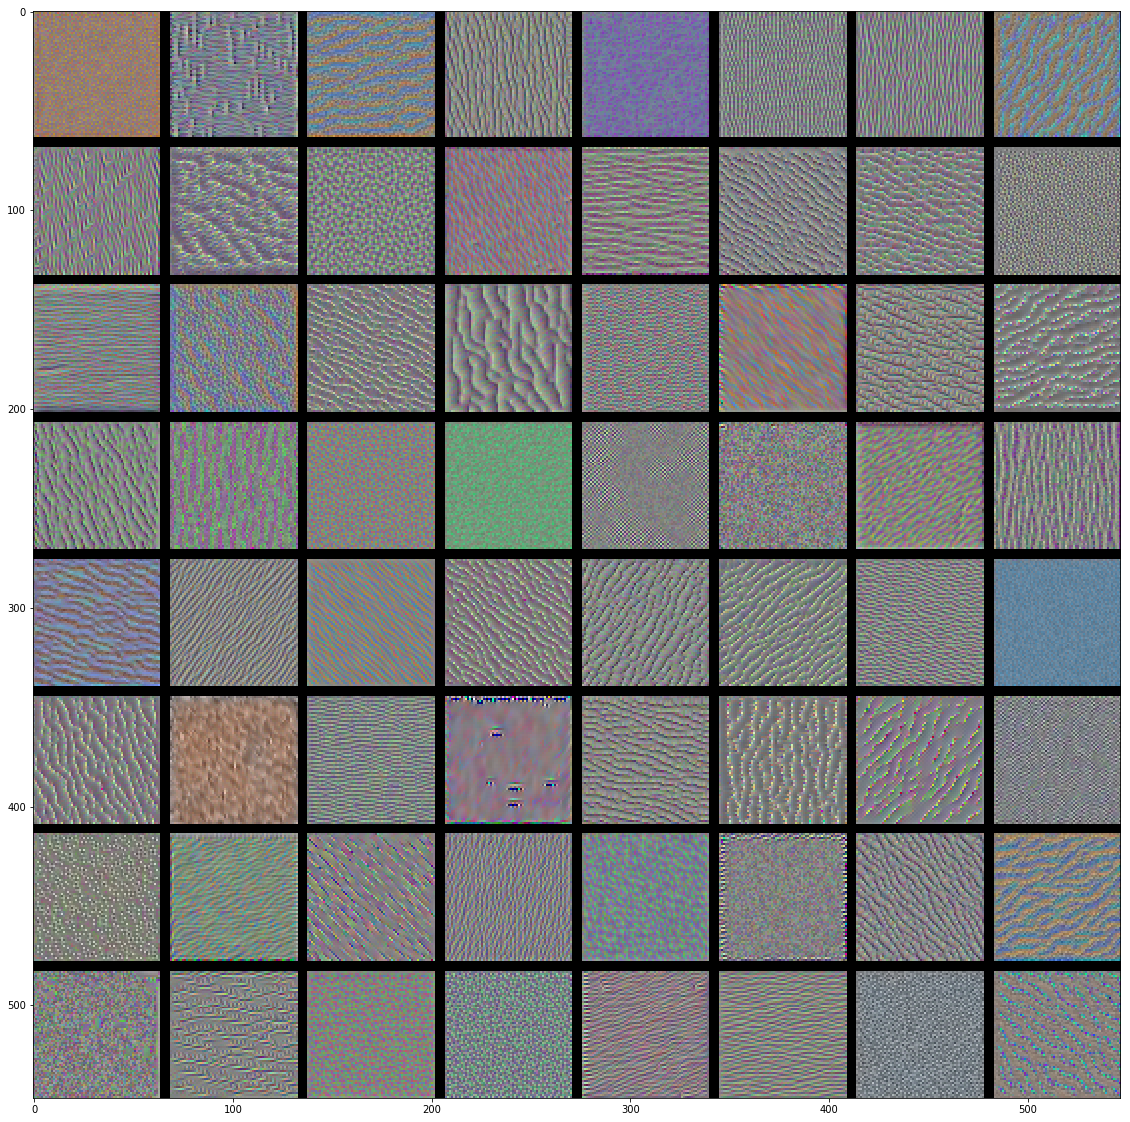

In [13]:
for layer_name in ['Conv2d_1a_7x7','Conv2d_2b_1x1','Conv2d_2c_3x3']:
    size = 64
    margin = 5

    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):
        for j in range(8):
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

In [14]:
grad = tf.gradients(logits[:,index], endpoints['Conv2d_2c_3x3'])[0]
pooled_grad = tf.reduce_mean(grad, axis=(0, 1, 2))
pooled_grad_value, conv_layer_output_value = sess.run([pooled_grad,endpoints['Conv2d_2c_3x3']],feed_dict={X:img})
conv_layer_output_value = conv_layer_output_value[0]
for i in range(int(pooled_grad.shape[0])):
    conv_layer_output_value[:, :, i] *= pooled_grad_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

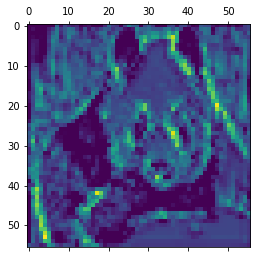

In [15]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [16]:
import cv2
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

In [17]:
cv2.imwrite('panda_heatmap.jpg', superimposed_img)

True

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


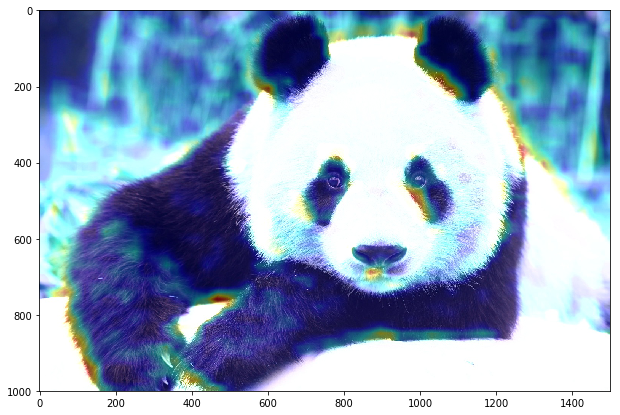

In [18]:
plt.figure(figsize=(15,7))
img_imposed = imread('panda_heatmap.jpg')
plt.imshow(img_imposed)
plt.show()